# Train on Conditional PMFs P(m|n)


First, load in modules.

In [2]:
import numpy as np
import time
from scipy import stats


import torch
import train_conditional as trc
import tools_conditional as ttc

Next, load in data. Data for conditional PMF training is stored in : 

1. '/home/mcarilli/CME/conditional_training_data'


'Parameter' vectors are stored as {$\textrm{log}_{10}(b), \textrm{log}_{10}(\beta),\textrm{log}_{10}(\gamma),n$},
where $n$ is the nascent RNA count at which to calculate the conditional distribution P(m|n).

In [3]:
path = '/home/mcarilli/CME/conditional_training_data/'

In [4]:
train_list,test_list = trc.get_file_paths(set_size = 256,
                                number_of_training_files=2,
                                 number_of_testing_files=1,total_files=5,file_path=path)

Calculating ypred at runtime! 

In [64]:
npdf = 10

def get_NORM(npdf,quantiles='lin'):
    if quantiles == 'lin':
        q = np.linspace(0,1,npdf+2)[1:-1]
        NORM = stats.norm.ppf(q)
        NORM = torch.tensor(NORM)
        return NORM
    if quantiles == 'cheb':
        n = np.arange(npdf)
        q = np.flip((np.cos((2*(n+1)-1)/(2*npdf)*np.pi)+1)/2)

        NORM = stats.norm.ppf(q)
        NORM = torch.tensor(NORM)
        return NORM

def generate_grid(npdf,VAR,MU,COV,m):
    logvar = torch.log((VAR/MU**2)+1)
    logstd = torch.sqrt(logvar)
    logmean = torch.log(MU**2/torch.sqrt(VAR+MU**2))

    logcov = torch.log(COV * torch.exp(-(logmean.sum()+logvar.sum()/2)) +1 ) 
    logcorr = logcov/torch.sqrt(logvar.prod())
#         print(type(m))
    logmean_cond = logmean[1] + logcorr * logstd[1]/logstd[0] * (torch.log(m+1) - logmean[0])
    logstd_cond = logstd[1] * torch.sqrt(1-logcorr**2)   

    translin = torch.exp(logmean_cond+logstd_cond*NORM)
    return translin

#     logstd = torch.sqrt(np.log((VAR/MU**2)+1))
#     logmean = torch.log(MU**2/np.sqrt(VAR+MU**2))
#     translin = torch.exp(logmean+logstd*NORM)
#     return(translin)


def get_ypred_at_RT(p,w,hyp,npdf=npdf,log=False):
    '''Given a parameter vector (tensor) and weights (tensor), and hyperparameter,
    calculates ypred (Y) at runtime.'''

    if log:
        n = torch.exp(p[3])-1
    else:
        n = p[3]
        
    p_vec = 10**p[:-1]
    
    # mean, variance, standard deviation of exact (2D) solution
    MU, VAR, STD, xmax = trc.get_moments(p_vec)
    
    COV = p_vec[0]**2/(p_vec[1] + p_vec[2])
    
#     # unpack mean, variance, STD for nascent and mature RNA 
    xmax_m = xmax[1]

    grid = generate_grid(npdf,VAR,MU,COV,n)
#     print(grid)
    
    s = torch.zeros(npdf)
#     s[0] = grid[0]
    s[:-1] = torch.diff(grid)
    s *= hyp
    s[-1] = torch.sqrt(grid[-1])
    
    v = s**2
#     if torch.any(v<grid):
#         v = torch.maximum(v,grid)
    r = grid**2/(v-grid)
    p_nb = 1-grid/v
    
#     r = (grid/s)**2 
#     p_nb = 1/(1+s**2/grid)
    xgrid = torch.arange(xmax_m+1)
    Y = torch.zeros(xmax_m+1)
    GAMMALN_XGRID = lnfactorial[1:len(xgrid)+1]
    
    if torch.isnan(sum(GAMMALN_XGRID)) == True:
        print(p_,'GAMMA')

    for i in range(npdf):
        l = -grid[i] + xgrid * torch.log(grid[i]) - GAMMALN_XGRID
        if (p_nb[i] >1e-10):
            l += torch.special.gammaln(xgrid+r[i]) - torch.special.gammaln(r[i]) \
                - xgrid*torch.log(r[i] + grid[i]) + grid[i] \
                + r[i]*torch.log(r[i]/(r[i]+grid[i]))
        Y += w[i]*torch.exp(l)

#     for i in range(npdf):
#         l = torch.special.gammaln(xgrid+r[i]) - GAMMALN_XGRID - torch.special.gammaln(r[i]) \
#             + xgrid*torch.log(1-p_nb[i]) + r[i]*torch.log(p_nb[i])
    
#         Y += w[i]*torch.exp(l)
    EPS=1e-50
    Y[Y<EPS]=EPS
    if torch.isnan(torch.sum(Y)) == True:
        print(p_vec,Y)
    
    return Y


In [6]:
import matplotlib.pyplot as plt

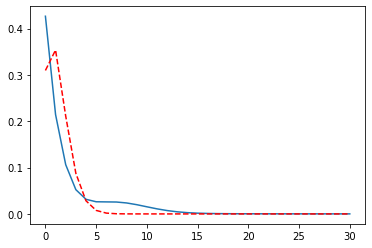

In [13]:
w_rand = np.random.rand(npdf)
w_rand /= w_rand.sum()

hyp = 1.5
j= 20
y=get_ypred_at_RT(torch.tensor(train_list[j][0]),w_rand,hyp,npdf=npdf)
plt.plot(y)
plt.plot(train_list[j][1],'r--')

Define NORM quantiles and lnfactorial.

In [8]:
NORM = get_NORM(npdf,quantiles='cheb')

# precalculate lngammas
lnfactorial = torch.special.gammaln(torch.arange(1003))

For cleaner training, set up model configurations and training configurations to pass to train. 

Model is 2 hidden layers, with user-defined dimensions.

Input dimension is 4 ('param vector' and n value), and output is npdf.

In [180]:
model_config = {
    'npdf' : 10,
    'h1_dim' : 128,
    'h2_dim' : 128,
    'norm_type' : 'softmax',
    'num_training_params': 200, #is this ever actually used? -- yes, in metadata 
}

train_config = {
    'num_epochs' : 10,
    'lr' : 1e-6,
    'batchsize' : 10,
    'metric' : 'kld',
}

norm_type options:
    1. 'softmax'
    2. 'normalize' (applies sigmoid so all are positive, then normalizes)
    3. None (takes absolute value of output weights)
   
metric options:
    1. 'kld'
    2. 'kld_normalized'
    3. 'totalse'
    4. 'mse'
    5. 'maxabsdev'
    6. 'maxabsdevlog'
    7. 'mselog'
    

## And Train

In [130]:
import importlib
importlib.reload(trc)

<module 'train_conditional' from '/home/mcarilli/CME/git/CME_approximations/Conditional/train_conditional.py'>

In [478]:
len(test_list)

38344

In [74]:
t1 = time.time()
e,t,model = trc.train(train_list[:200],test_list[:200],model_config,train_config,get_ypred_at_RT)
t2 = time.time()

dt = t2-t1
print(t2-t1)

Epoch Number: 0
Epoch Number: 1
Epoch Number: 2
Epoch Number: 3
Epoch Number: 4
Epoch Number: 5
Epoch Number: 6
Epoch Number: 7
Epoch Number: 8
Epoch Number: 9
16.637595415115356


Save the model and meta data.

Will save two files: 
    1. 'path/name_MODEL'
    2. 'path/name_meta.npy'

In [452]:
!mkdir -p models

In [453]:
# ttc.save_model_and_meta(model,model_config,train_config,time,path,name)

#example:
# ttc.save_model_and_meta(model,model_config,train_config,time=dt,path='./models/',name='gg_220410_1k')

Then, to load it in, I have defined a class Trained_Model.

This includes:
    1. example_model.model_configs (dictionary of model configurations) 
    2. example_model.train_configs (dictionary of training configurations)
    3. example_model.time (time it took to train)
    4. example_model.model (actual model)
    

In [454]:
# example_model = ttc.Trained_Model(path, name)

#example:
#save_model_and_meta('./models/','20220410_')

-----

## Validation and Plotting

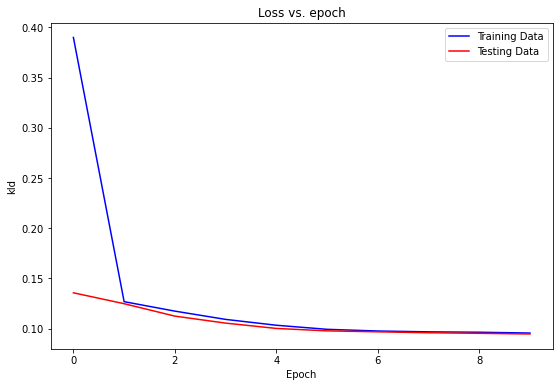

In [76]:
ttc.plot_training(e,t,metric='kld')

In [73]:
metrics,metric_mean = trc.calculate_test_metrics(test_list[:100],model,get_ypred_at_RT,metric='kld')

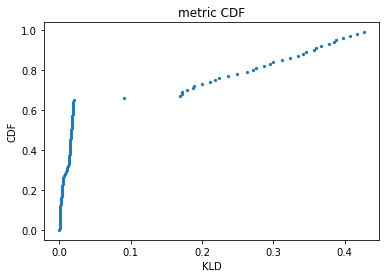

In [23]:
ttc.plot_CDF(metrics)

In [176]:
import importlib
importlib.reload(trc)

<module 'train_conditional' from '/home/mcarilli/CME/git/CME_approximations/Conditional/train_conditional.py'>

But if we train again, with more data...

In [181]:
t1 = time.time()
e,t,model = trc.train(train_list[0:500],test_list[:20],model_config,train_config,get_ypred_at_RT)
t2 = time.time()

dt = t2-t1
print(t2-t1)

Epoch Number: 0
Epoch Number: 1
Epoch Number: 2
Epoch Number: 3
Epoch Number: 4
Epoch Number: 5
Epoch Number: 6
Epoch Number: 7
Epoch Number: 8
Epoch Number: 9
20.74242925643921


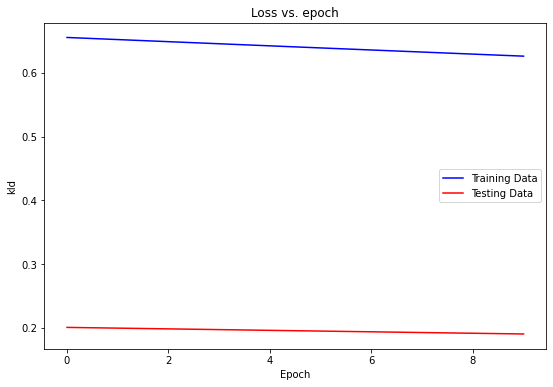

In [182]:
ttc.plot_training(e,t)


Let's try transforming.

In [489]:
import copy

In [508]:
train_list_log = copy.deepcopy(train_list)
test_list_log = copy.deepcopy(test_list)

In [509]:
test_list_log[0][0]

array([ 0.26555198, -0.77010268,  0.3630054 ,  0.        ])

In [510]:
for i in range(len(test_list_log)):
    test_list_log[i][0][-1] = np.log(test_list_log[i][0][-1] + 1)
for i in range(len(train_list_log)):
    train_list_log[i][0][-1] = np.log(train_list_log[i][0][-1] + 1)

In [511]:
t1 = time.time()
ypred_fun = lambda p,w,hyp: get_ypred_at_RT(p,w,hyp,log=True)
e,t,model = trc.train(train_list_log[:1000],test_list_log[:200],model_config,train_config,ypred_fun)
t2 = time.time()

dt = t2-t1
print(t2-t1)

Epoch Number: 0
Epoch Number: 1
Epoch Number: 2
Epoch Number: 3
Epoch Number: 4
Epoch Number: 5
Epoch Number: 6
Epoch Number: 7
Epoch Number: 8
Epoch Number: 9
23.971375465393066


In [512]:
model.input.weight

Parameter containing:
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        ...,
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]], requires_grad=True)

doesn't work :(

In [399]:
# ttc.plot_histogram(metrics,bins,metric='kld')

In [ ]:
# test_list[:2]

doesn't work yet.

In [104]:
ttc.plot_PMF_grid(test_list[:25],npdf,5,5,model,get_ypred_at_RT,kld=True)

IndexError: index 0 is out of bounds for dimension 0 with size 0

In [461]:
ttc.plot_param_quantiles(klds=metrics,train_list=test_list,model=model)

NameError: name 'rt1' is not defined